In [1]:
from collections import Counter
from math import log10
from pprint import pprint
from typing import List, Dict, Tuple

import requests
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare

In [2]:
url = "https://county.milwaukee.gov/EN/County-Clerk/Off-Nav/Election-Results/Election-Results-Fall-2020"
candidates = ['Biden', 'Trump', 'Blankenship', 'Jorgensen', 'Carroll']

In [3]:
def get_soup(url:str):
    """get html data from input url and load it into beautifulsoup parser

    Args:
        url (str): source url

    Returns:
        beautifulsoup parser with loaded data
    """
    headers = { 'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:82.0) Gecko/20100101 Firefox/82.0" }

    response = requests.get(url, headers=headers)
    if response.status_code != requests.codes.ok:
        print("ERROR")
        return None

    data = response.text
    soup = bs(data, "html.parser")
    return soup

In [4]:
def get_benfords() -> List[float]:
    """get list of expected discrete benford distribution values to be used for chi square test

    Returns:
        List[float]: discrete benford's law distribution
    """
    benfords = [log10(1 + 1/d) for d in range(1, 10)]
    return benfords

In [5]:
def data_parsing(soup) -> Dict[str, List[str]]:
    """Take a beautiful soup object and parse it into a dict with corresponding candidate names
    and lists of their vote counts for precincts

    Args:
        soup ([type]): [description]

    Returns:
        Dict[str, List[str]]: [description]
    """
    
    precinct_table = soup.findAll('table', {'class': 'precinctTable'})
    federal_table = precinct_table[1]

    data = {
        "Num": [],
        "Ward": [],
        "Biden": [],
        "Trump": [],
        'Blankenship': [],
        'Jorgensen': [],
        'Carroll': [],
        'writein': []
    }
    count = 1
    header = True

    for val in federal_table.findAll('td'):
        if header and count != 8:
            count += 1
            continue
        elif header and count == 8:
            count = 1
            header = False
            continue

        if count == 1:
            data['Num'].append(val.text)
        elif count == 2:
            data['Ward'].append(val.text)
        elif count == 3:
            data['Biden'].append(val.text)
        elif count == 4:
            data['Trump'].append(val.text)
        elif count == 5:
            data['Blankenship'].append(val.text)
        elif count == 6:
            data['Jorgensen'].append(val.text)
        elif count == 7:
            data['Carroll'].append(val.text)
        elif count == 8:
            data['writein'].append(val.text)
            count = 0

        count += 1

    # remove last data point, which is the total of all vote counts
    data = {k: v[:-1] for k, v in data.items()}

    return data

In [6]:
def preprocess(data: Dict[str, List[str]]) -> Tuple[Dict[str, List[int]], Dict[str, List[float]]]:
    """preprocess a dictionary of candidate name and votes and generate counts of the leading digits
    and the expected values using Benford's Law

    Args:
        data (Dict[str, List[str]]): candidate and vote counts for all prescints

    Returns:
        Tuple[Dict[str, List[int]], Dict[str, List[float]]]: observed and expected leading digit count
            for all candidates
    """
    # get leading digit for precinct votes of all candidates
    data = {k: list(map(lambda x: int(str(x)[0]), v)) for k, v in data.items() if k in candidates}

    # get counter of leading digits for all candidates
    data = {k: Counter(v) for k, v in data.items()}

    # sorted count of leading digits for all candidates, where index 0 correspond to counts of 1, index 2 correspond to counts of 2
    data_observed = {k: list(dict(sorted(v.items(), key = lambda x: x[0])).values())[1:] for k, v in data.items()}

    benfords = get_benfords()
    data_expected = {k: [sum(v) * b for b in benfords][:len(v)] for k, v in data_observed.items()}

    data_observed['axis'] = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    data_expected['axis'] = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    return data_observed, data_expected

In [7]:
soup = get_soup(url)
data = data_parsing(soup)
observed, expected = preprocess(data)


In [8]:
def visualize(candidate:str = None):
    if not candidate:
        fig = sns.barplot(data=expected, x='axis', y='Biden', color='gray')
        fig.set(xlabel='leading digits', ylabel='counts', title="Benford's Law distribution")
        return fig
        
    ax = sns.barplot(x='axis',
                 y=candidate,
                 data=expected,
                 color='gray',
                 saturation=0.5,
                 alpha=0.2,
                 label="expected")
    ax2 = ax.twinx()
    ax2.plot(ax.get_xticks(), observed[candidate], label='observed')
    ax2.set_ylim(0, 150)
    ax.set(xlabel='leading digits', ylabel='counts', title=f"{candidate} - Benford's Count - Observed vs Expected")
    ax.legend(bbox_to_anchor=(1, 0.92))
    ax2.legend()

    return ax

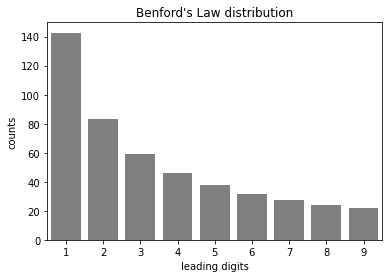

In [9]:
visualize();

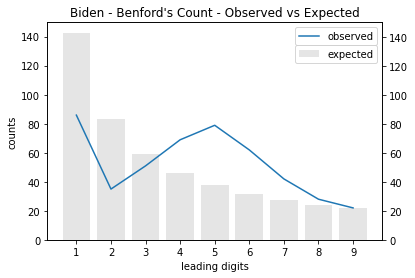

In [10]:
visualize('Biden');

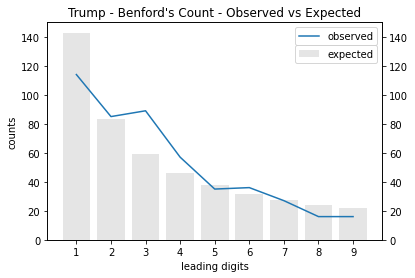

In [11]:
visualize('Trump');

In [12]:
chi_square_results = {candidate: chisquare(observed[candidate], expected[candidate]) for candidate in candidates}
pprint(chi_square_results)

{'Biden': Power_divergenceResult(statistic=146.32065425194043, pvalue=1.1467698266391095e-27),
 'Blankenship': Power_divergenceResult(statistic=112.7312717929695, pvalue=2.4889575100879005e-21),
 'Carroll': Power_divergenceResult(statistic=93.2719008448592, pvalue=6.328417059002513e-18),
 'Jorgensen': Power_divergenceResult(statistic=14.075894069964027, pvalue=0.07980858714665816),
 'Trump': Power_divergenceResult(statistic=28.423612737925943, pvalue=0.0004000551255609517)}


Text(0.5, 1.0, 'Biden Vote Count distribution')

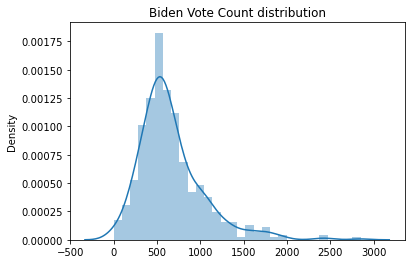

In [18]:
sns.distplot(data['Biden']).set_title("Biden Vote Count distribution")